In [4]:
# Import librarys
from run_ac import *
import os
from tqdm import tqdm
import time
from func import *
import geopandas as gpd
from matplotlib import pyplot as plt

In [5]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [6]:
# Replace the timestamp from LAI
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

# Replace first 48 days with them from 2001
torep = lai_data.sel(time = slice("2001-01-01","2001-02-17"))
lai_data.values[0:48, :, :] = torep.values

# Fill gaps in LAI
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        if np.isnan(lai_data[:, lat, lon]).all():
            continue
        else:
            # Get the data for the current grid cell
            grid_cell_data = lai_data[:, lat, lon]
            
            # Convert to DataFrame for easier handling
            grid_cell_df = pd.DataFrame(grid_cell_data)
            
            # Fill NA values with the previous value
            grid_cell_df.fillna(method='ffill', inplace=True)
            
            # Update the grid cell data
            lai_data[:, lat, lon] = grid_cell_df.values.flatten()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ff

## Run model with present data

In [7]:
# Prepare data for new model
full_data = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 1] = R_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

In [8]:
# Run model
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results = time_evolution(full_data, *params)

current = out2xarray(results)

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 8495.16it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [60]:
def rem_trend(data):
    # Convert temperature data to numpy array
    data_array = data.values

    # Reshape the data into 2D array (time, spatial dimensions)
    time_length = len(data.time)
    spatial_dims = data.shape[1:]
    data_2d = data_array.reshape((time_length, -1))

    # Detrend each grid cell separately
    detrended_data = np.zeros_like(data_2d)
    for i in range(data_2d.shape[1]):
        mean_value = np.mean(data_2d[:,i], axis=0)
        detrended_data[:, i] = detrend(data_2d[:, i], axis=0, type='linear')
        detrended_data[:, i] = detrended_data[:, i] + mean_value

    # Reshape detrended data back to its original shape
    output = xr.DataArray(detrended_data.reshape((time_length,) + spatial_dims),
                          coords=data.coords, dims=data.dims)

    return output

## Detrend data

In [61]:
T_data_detrend = rem_trend(T_data)
R_data_detrend = rem_trend(R_data)

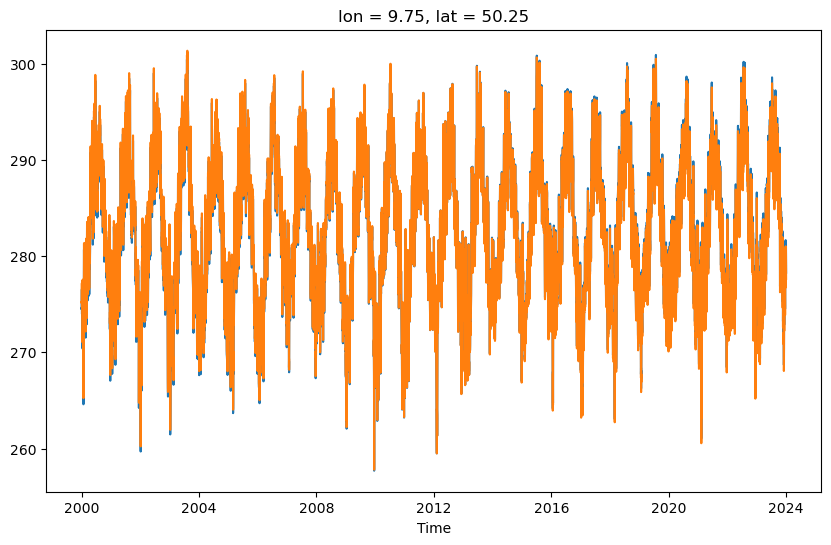

In [62]:
plt.figure(figsize=(10, 6))
T_data.isel(lat=10, lon=10).plot(x='time')
T_data_detrend.isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

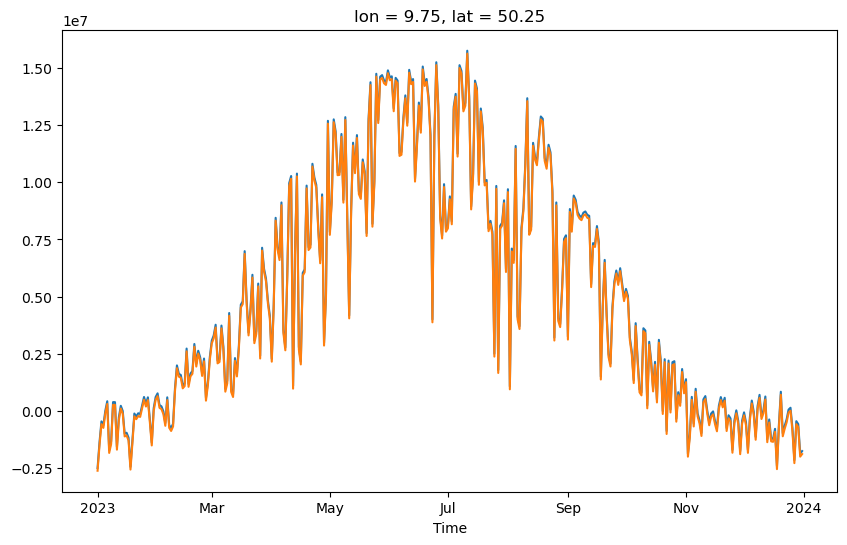

In [63]:
plt.figure(figsize=(10, 6))
R_data.sel(time='2023').isel(lat=10, lon=10).plot(x='time')
R_data_detrend.sel(time='2023').isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

## Prepare model for detrended data

In [64]:
# Prepare detrendeddata for new model
full_data_detrend = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data_detrend[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data_detrend[:, :, :, 1] = R_data_detrend.transpose('lat', 'lon', 'time')
full_data_detrend[:, :, :, 2] = T_data_detrend.transpose('lat', 'lon', 'time')
full_data_detrend[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

In [65]:
# Run model
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
results_detrend = time_evolution(full_data_detrend, *params)

current_detrend = out2xarray(results_detrend)

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 6956.77it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [66]:
diffrence = current - current_detrend

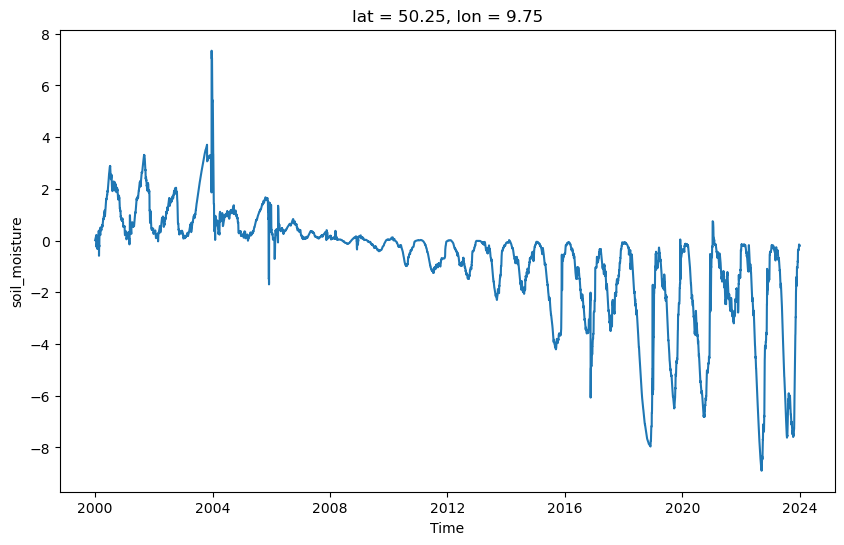

In [67]:
plt.figure(figsize=(10, 6))
(diffrence['soil_moisture']).isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

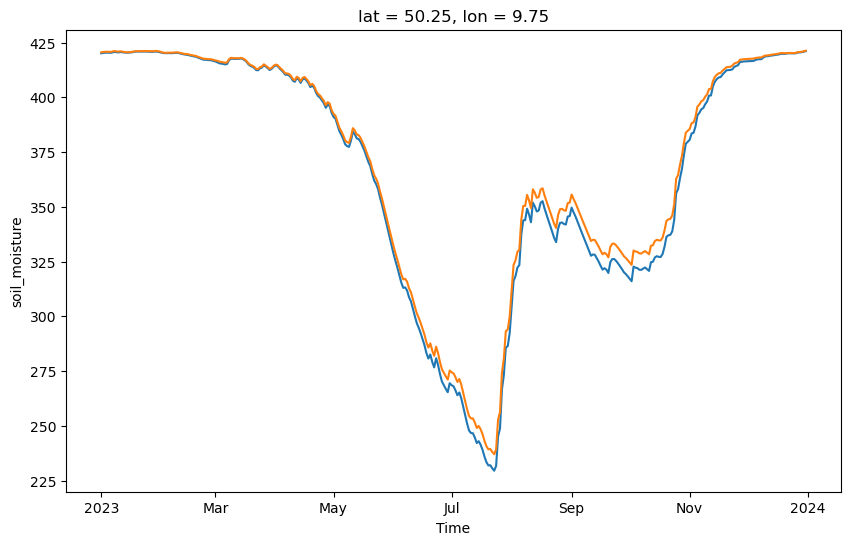

In [68]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
current_detrend['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

In [69]:
current_mean = current.mean(dim='time')

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\4209045016.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


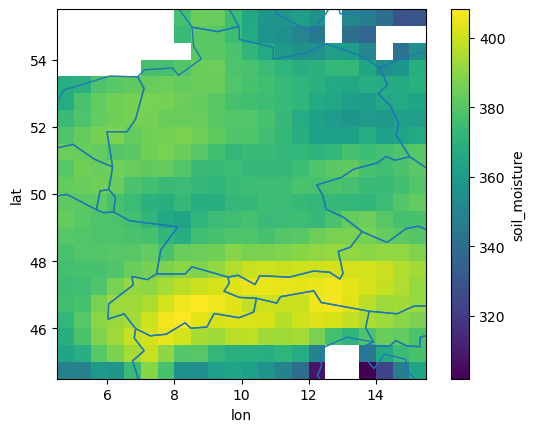

In [70]:

# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
current_mean['soil_moisture'].plot()

# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

In [71]:
dif_per = diffrence / current_mean

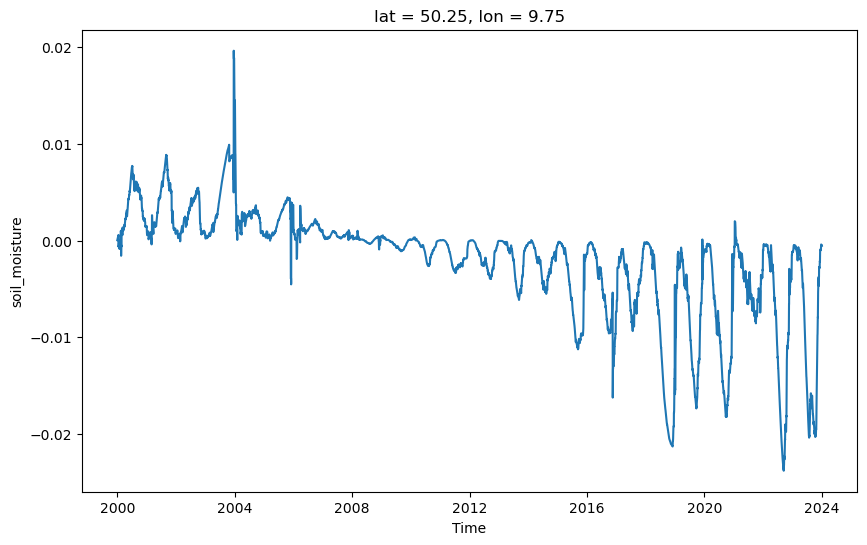

In [72]:
plt.figure(figsize=(10, 6))
dif_per['soil_moisture'].isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

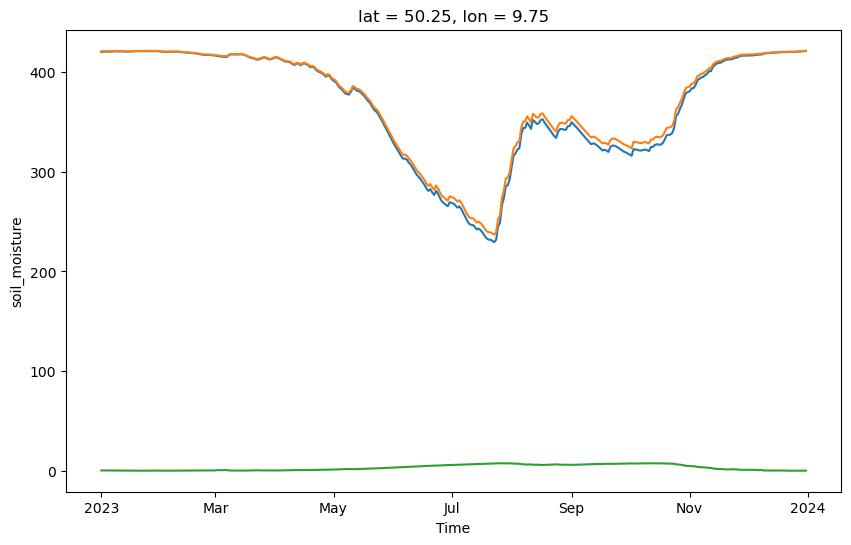

In [73]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
current_detrend['soil_moisture'].sel(time='2023').isel(lat=10, lon=10).plot(x='time')
abs(diffrence['soil_moisture']).sel(time='2023').isel(lat=10, lon=10).plot(x='time')
plt.xlabel('Time')
plt.show()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\3458899805.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


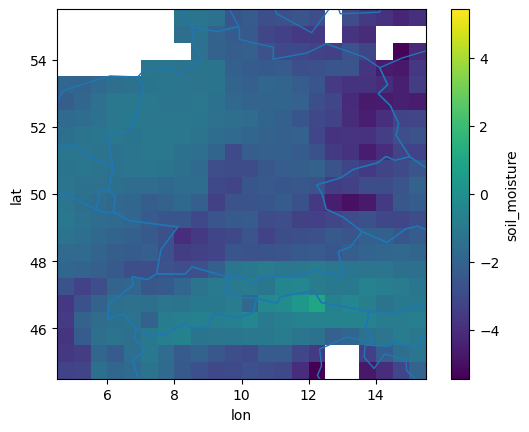

In [77]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
diffrence['soil_moisture'].sel(time='2023').mean(dim='time').plot(cmap ='viridis')


# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

C:\Users\motze\AppData\Local\Temp\ipykernel_9992\942929512.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


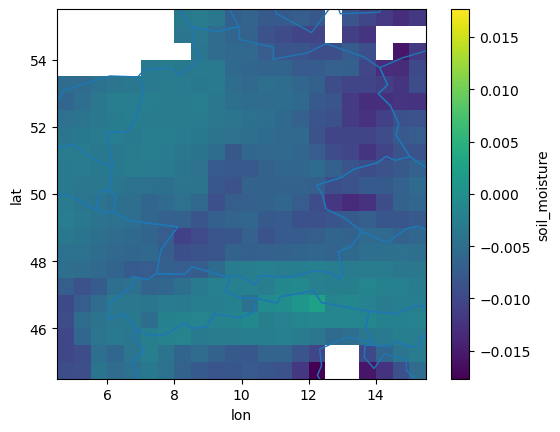

In [78]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
dif_per['soil_moisture'].sel(time='2023').mean(dim='time').plot(cmap ='viridis')


# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

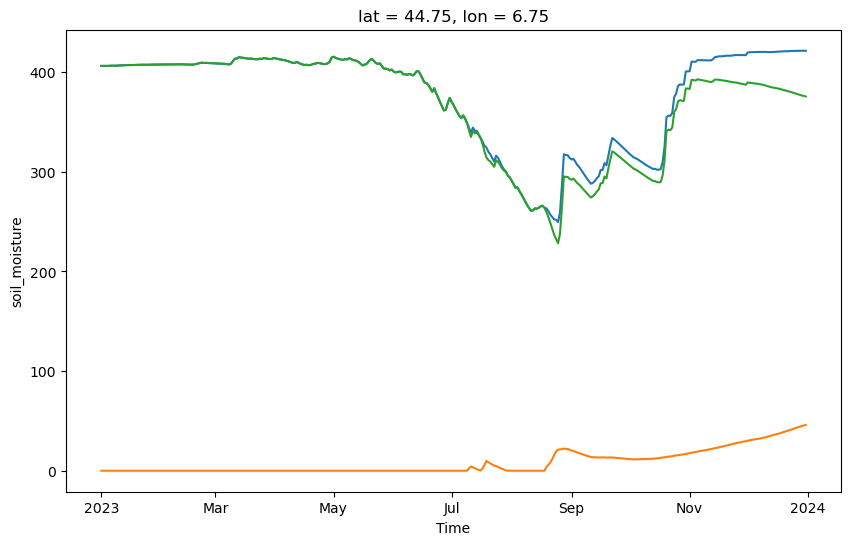

In [55]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time')
current_detrend['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time')
diffrence['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

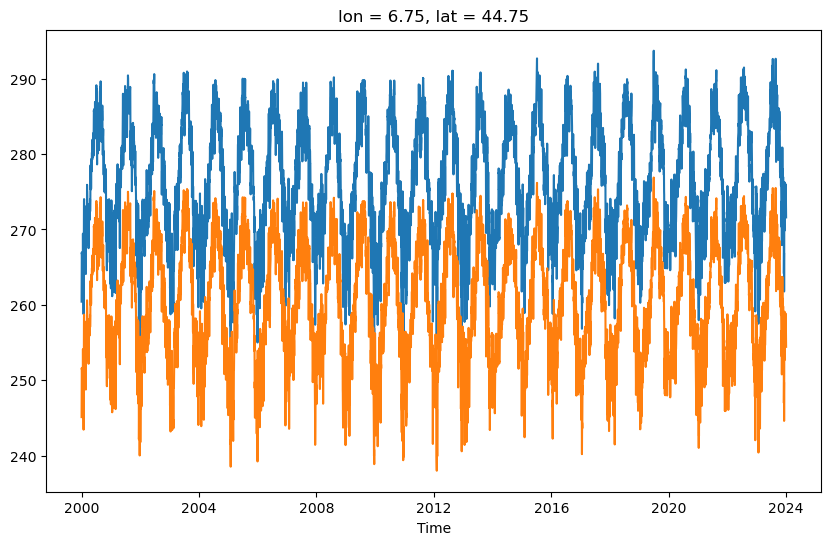

In [56]:
plt.figure(figsize=(10, 6))
T_data.isel(lat=21, lon=4).plot(x='time')
T_data_detrend.isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

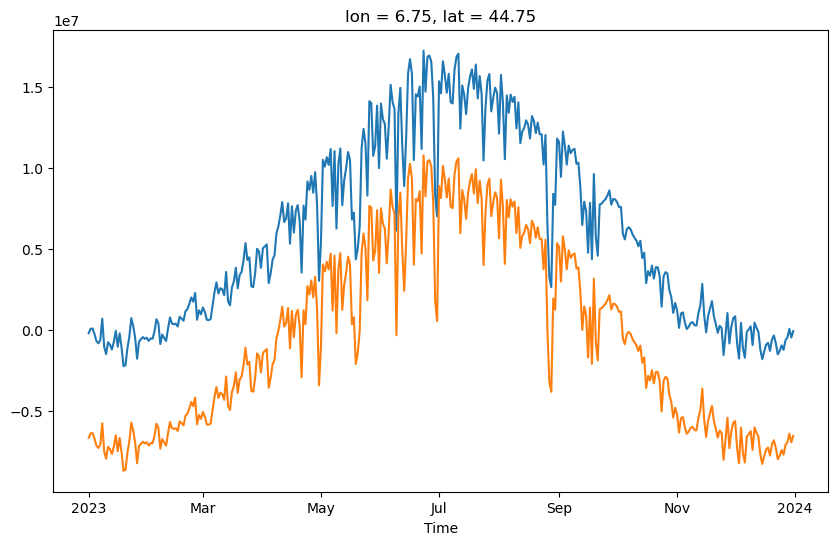

In [57]:
plt.figure(figsize=(10, 6))
R_data.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
R_data_detrend.sel(time='2023').isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

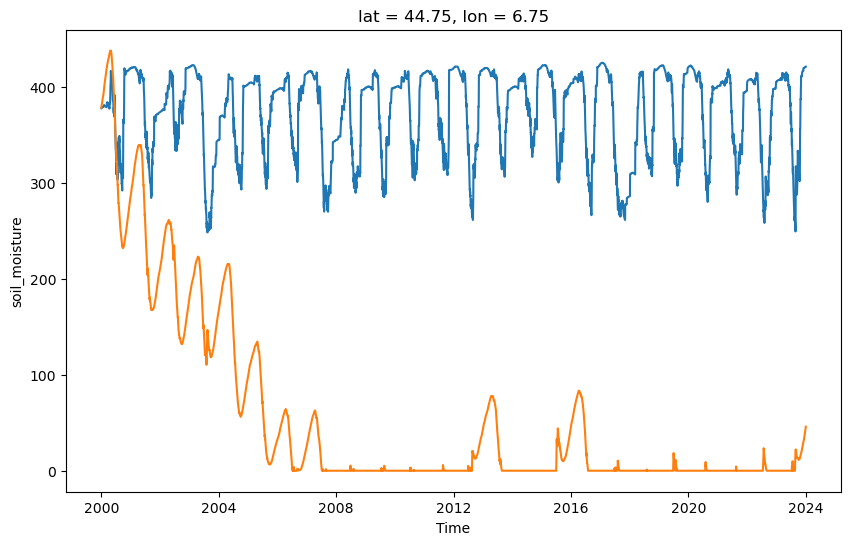

In [58]:
plt.figure(figsize=(10, 6))
current['soil_moisture'].isel(lat=21, lon=4).plot(x='time')
current_detrend['soil_moisture'].isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

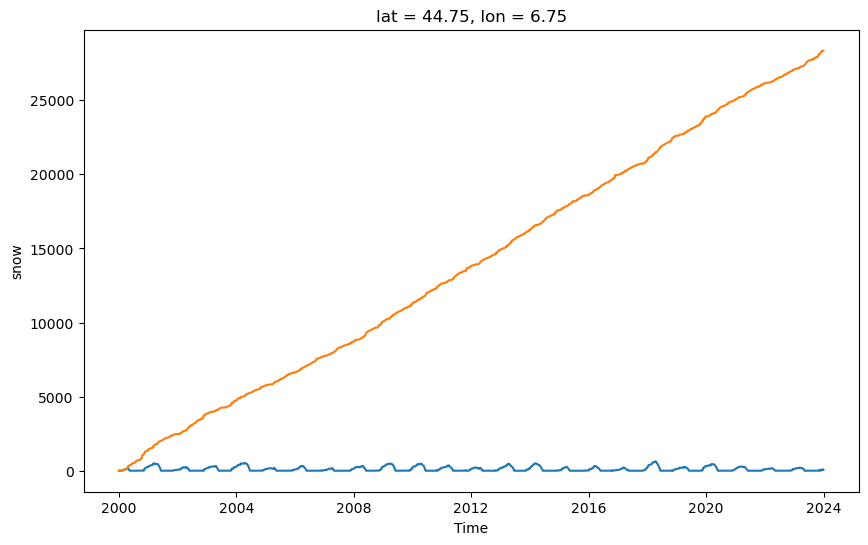

In [59]:
plt.figure(figsize=(10, 6))
current['snow'].isel(lat=21, lon=4).plot(x='time')
current_detrend['snow'].isel(lat=21, lon=4).plot(x='time')
plt.xlabel('Time')
plt.show()

## Multiply trend

In [79]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

In [81]:
T_data

<xarray.DataArray 't2m' (time: 8766, lat: 22, lon: 22)> Size: 34MB
array([[[280.59121704, 280.63598633, 280.74398804, ..., 276.04473877,
         276.31143188, 276.39883423],
        [280.72033691, 280.7762146 , 280.84567261, ..., 275.9569397 ,
         275.89819336, 275.94161987],
        [280.82891846, 280.81845093, 280.74420166, ..., 275.10351562,
         275.02243042, 274.78271484],
        ...,
        [277.40808105, 276.24545288, 273.47494507, ..., 268.12973022,
         267.09375   , 268.89385986],
        [276.92376709, 275.38397217, 270.79888916, ..., 273.62792969,
         270.76239014, 270.2572937 ],
        [277.01269531, 273.97784424, 268.38330078, ..., 278.74215698,
         275.77294922, 272.18087769]],

       [[280.33605957, 280.42529297, 280.56161499, ..., 277.43771362,
         277.59838867, 277.67483521],
        [280.46069336, 280.56558228, 280.671875  , ..., 277.33364868,
         277.37185669, 277.42602539],
        [280.69180298, 280.71704102, 280.68875122, ..., 276.69320679,
         276.72375488, 276.69949341],
...
        [280.00878906, 279.86636353, 279.08499146, ..., 280.19708252,
         280.42745972, 281.0625    ],
        [279.52642822, 279.2444458 , 276.89151001, ..., 282.83169556,
         282.12698364, 281.89483643],
        [279.74801636, 278.52993774, 275.49841309, ..., 286.00817871,
         284.52163696, 282.37158203]],

       [[281.73876953, 281.80743408, 281.86199951, ..., 278.11514282,
         278.37420654, 278.35626221],
        [281.86810303, 281.90148926, 281.96569824, ..., 278.57293701,
         278.54605103, 278.47235107],
        [281.93450928, 281.99084473, 282.06243896, ..., 278.23956299,
         278.16461182, 277.86233521],
        ...,
        [281.02099609, 280.4670105 , 278.25726318, ..., 281.18490601,
         281.21813965, 281.98092651],
        [280.53823853, 280.34777832, 277.01409912, ..., 283.48178101,
         282.3147583 , 282.19747925],
        [280.80581665, 279.90960693, 276.3354187 , ..., 286.48043823,
         284.650177  , 282.19958496]]])
Coordinates:
  * lon      (lon) float64 176B 4.75 5.25 5.75 6.25 ... 13.75 14.25 14.75 15.25
  * lat      (lat) float64 176B 55.25 54.75 54.25 53.75 ... 45.75 45.25 44.75
  * time     (time) datetime64[ns] 70kB 2000-01-01 2000-01-02 ... 2023-12-31
Attributes:
    long_name:              2 metre temperature
    units:                  K
    standard_name:          air_temperature
    comment:                near-surface (usually, 2 meter) air temperature
    cds_magics_style_name:  near-surface-air-temperature
    type:                   real

In [90]:
test = T_data[:,0,0].values

In [94]:
time = np.arange(len(T_data))

In [96]:
len(time)

8766

In [97]:
slope, intercept, _, _, _ = stats.linregress(time, test)

In [98]:
slope

0.0001063548502002663

In [100]:
new_values = time * slope

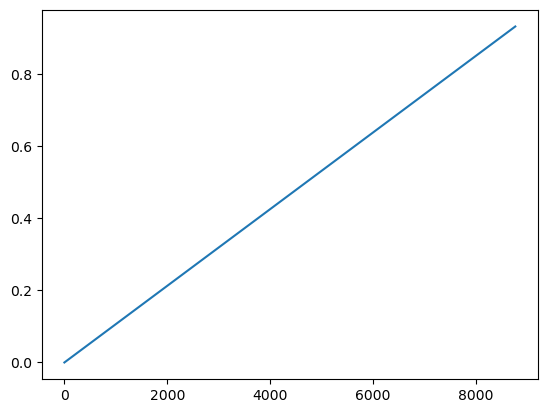

In [106]:
plt.plot(new_values)

In [107]:
T2 = T_data[:,0,0] + new_values

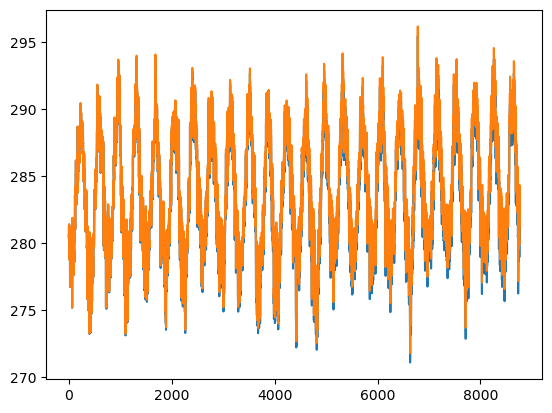

In [108]:
plt.plot(T_data[:,0,0])
plt.plot(T2)